In [ ]:
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
# Download the dataset from Mendeley data
# CBIS-DDSM would be a much better choice: https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=22516629#22516629accaef0469834754b89af9e007760b10
!wget -O mydataset.rar https://data.mendeley.com/public-files/datasets/ywsbh3ndr8/files/a49dc1cc-7a9e-422a-b3d4-a77cd908f594/file_downloaded

--2023-03-31 14:51:47--  https://data.mendeley.com/public-files/datasets/ywsbh3ndr8/files/a49dc1cc-7a9e-422a-b3d4-a77cd908f594/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/0ead233f-b56d-42bb-9c53-7cc246f259ce [following]
--2023-03-31 14:51:48--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/0ead233f-b56d-42bb-9c53-7cc246f259ce
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.1.16, 52.218.30.200, 52.218.25.128, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.1.16|:443

In [ ]:
!pip install rarfile
import rarfile

# Specify the path to the RAR file and the destination directory
rar_path = '/content/mydataset.rar'
extract_dir = '/content'

os.makedirs(extract_dir, exist_ok=True)

# Open the RAR file and extract its contents to the destination directory
with rarfile.RarFile(rar_path) as rf:
  rf.extractall(extract_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-4-8270a9942838>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  benign_img = imageio.imread(benign_path + b_img)
<ipython-input-4-8270a9942838>:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  malignant_img = imageio.imread(malignant_path + m_img)


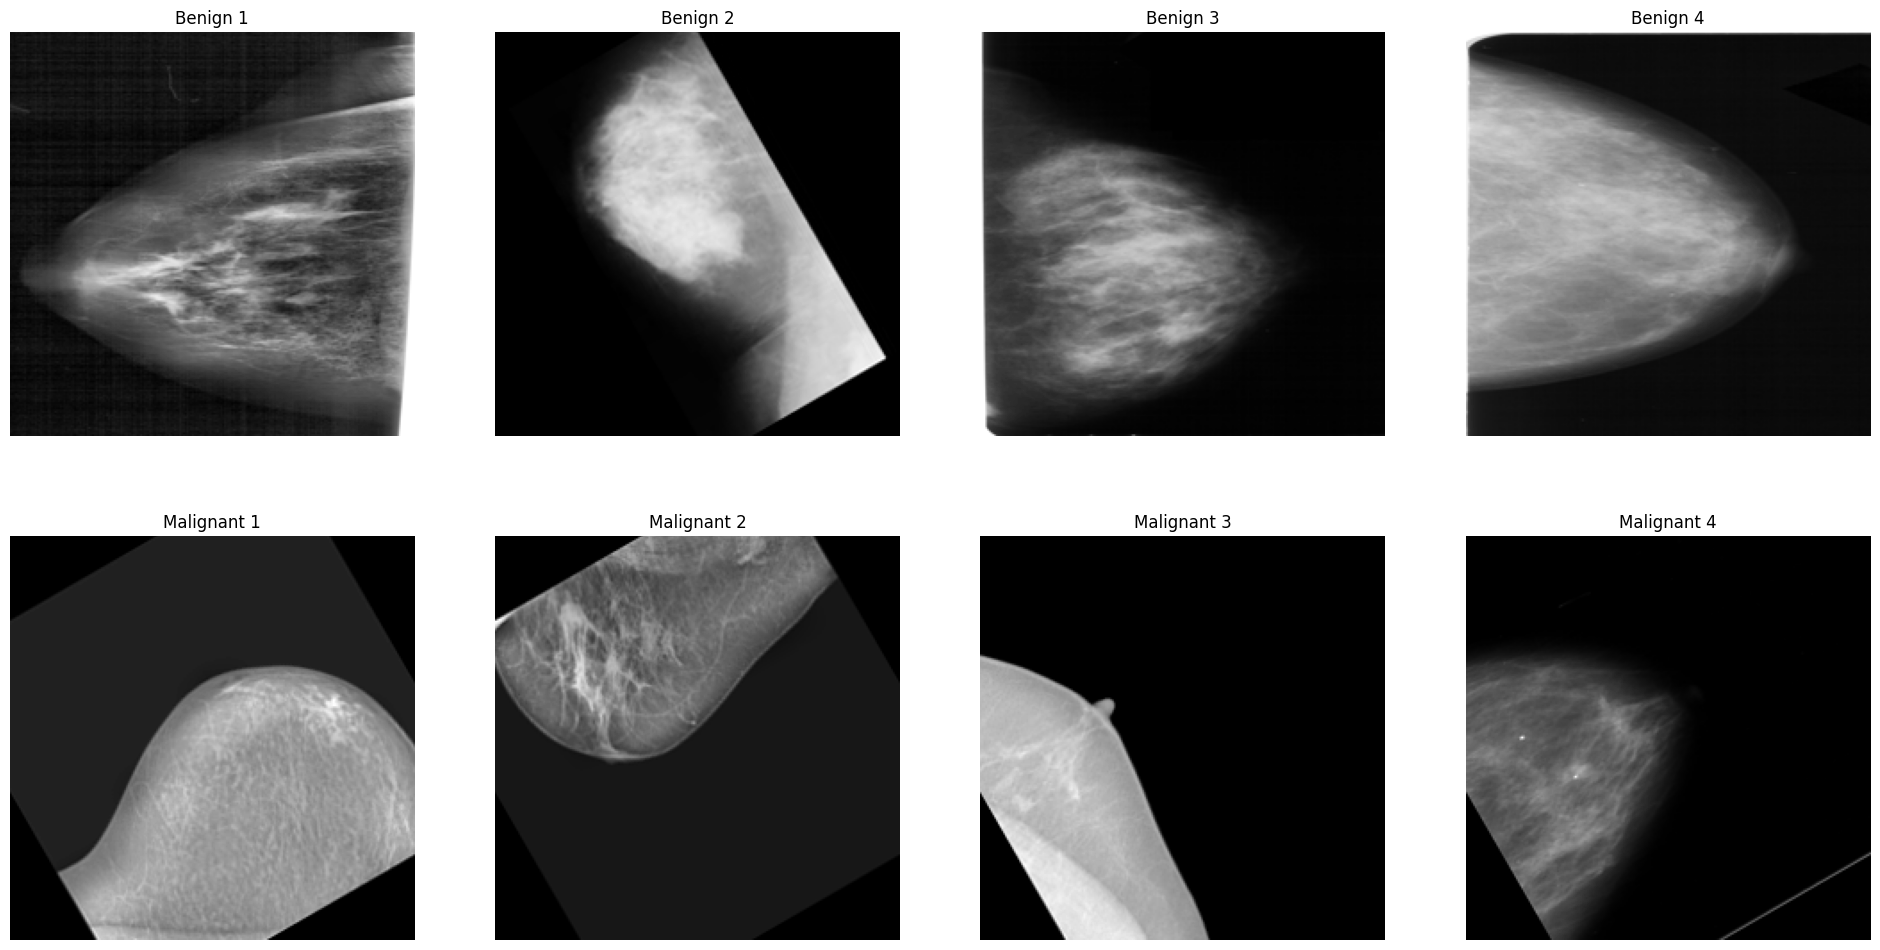

In [ ]:
data_path = "/content/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset"
benign_path = data_path + "/Benign Masses/"
malignant_path = data_path + "/Malignant Masses/"

benign_imgs = [i for i in os.listdir(benign_path)]
random_benign_samples = random.sample(benign_imgs, 4)

malignant_imgs = [i for i in os.listdir(malignant_path)]
random_malignant_samples = random.sample(malignant_imgs, 4)

fig, axs = plt.subplots(2, 4, figsize=(24,12))
for i, (b_img, m_img) in enumerate(zip(random_benign_samples, random_malignant_samples)):
    # Load the image
    benign_img = imageio.imread(benign_path + b_img)
    # Display the image
    axs[0, i].imshow(benign_img, cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Benign {}".format(i+1))
    
    malignant_img = imageio.imread(malignant_path + m_img)
    # Display the image
    axs[1, i].imshow(malignant_img, cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title("Malignant {}".format(i+1))
plt.show()

In [ ]:
from sklearn.utils import shuffle

def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2

class BreastImageSet(Dataset):
  """ Brain image set """
  def __init__(self, image_paths, labels=[0,1]):
    self.image_paths = image_paths
    self.images = []
    self.labels = []

    image_names_ = []
    for image_path in image_paths:
      image_names_.append(sorted(os.listdir(image_path)))

    for i, image_names in enumerate(image_names_):
      for image_name in image_names:
        if image_name.endswith('.png'):
          # Read the image
          image = imageio.imread(os.path.join(image_paths[i], image_name))
          self.images += [image]
          self.labels.append(labels[i])
    self.images, self.labels = shuffle(self.images, self.labels, random_state=101)
    self.labels = np.eye(len(labels))[self.labels]

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = normalise_intensity(self.images[idx])
    label = self.labels[idx]
    return image, label

  def get_tr_random_batch(self, batch_size):
    images, labels = [], []
    indices = np.random.choice(int(len(self)*0.8), batch_size)
    for idx in indices:
      image, label = self[idx]
      image = np.expand_dims(image, axis=0)
      images.append(image)
      labels.append(label)
    return images, labels

  def get_val_random_batch(self, batch_size):
    images, labels = [], []
    indices = np.random.choice(int(len(self)*0.2), batch_size)
    for idx in indices:
      image, label = self[idx+int(len(self)*0.8)]
      image = np.expand_dims(image, axis=0)
      images.append(image)
      labels.append(label)
    return images, labels

In [ ]:
#@title My Model (not used in the following code)
class MammogramClassifier(nn.Module):
  def __init__(self, num_filter=64):
    super(MammogramClassifier, self).__init__()

    #227*227
    n = num_filter  # 64
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    #113*113
    n *= 2 #128
    self.conv2 = nn.Sequential(
      nn.Conv2d(n//2, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    #56*56
    n *= 2 #256
    self.conv3 = nn.Sequential(
      nn.Conv2d(n//2, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    #28*28
    n *= 2 #512
    self.conv4 = nn.Sequential(
      nn.Conv2d(n//2, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.pool4 = nn.MaxPool2d(kernel_size=2)
    #14*14
    self.conv5 = nn.Sequential(
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.Conv2d(n, n, kernel_size=3, padding='same'),
      nn.ReLU()
    )
    self.pool5 = nn.MaxPool2d(kernel_size=2)
    #7*7
    self.fc1 = nn.Linear(512 * 7 * 7, 1024)
    self.fc2 = nn.Linear(1024, 1024)
    self.fc3 = nn.Linear(1024, 1)
    self.sigmoid = nn.Sigmoid()
      
  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.conv4(x)
    x = self.pool4(x)
    x = self.conv5(x)
    x = self.pool5(x)
    x = x.view(x.size(0), -1)  # flatten to a batch of samples
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.sigmoid(x)
    return x

In [ ]:
def accuracy(logits, labels, threshold=0.5):
    # Convert one-hot encoded labels to class indices
    labels = torch.argmax(labels, dim=1)
    
    preds = (torch.sigmoid(logits) > threshold).float()
    preds = torch.argmax(preds, dim=1)
    
    correct = (preds == labels).float().sum()
    total = labels.shape[0]
    
    return correct / total

In [ ]:
def train_model(model, dataset, criterion, optimizer, num_epochs, batch_size=16):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print('Device: {0}'.format(device))
  model.to(device)
  
  for epoch in range(1, num_epochs+1):
    model.train()
    images, labels = dataset.get_tr_random_batch(batch_size)
    images, labels = torch.from_numpy(np.array(images)), torch.from_numpy(np.array(labels))
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
    logits = model(images)

    optimizer.zero_grad()
    train_loss = criterion(logits, labels)
    train_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      model.eval()
      # Disabling gradient calculation during reference to reduce memory consumption
      with torch.no_grad():
        # Evaluate on a batch of test images and print out the test loss
        ### Insert your code ###
        test_images, test_labels = dataset.get_val_random_batch(64)
        test_images, test_labels = torch.from_numpy(np.array(test_images)), torch.from_numpy(np.array(test_labels))
        test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.float32)
        test_logits = model(test_images)
        test_loss = criterion(test_logits, test_labels)
        train_acc = accuracy(logits, labels)
        test_acc = accuracy(test_logits, test_labels)
        print("Iter:{:5d}  |  Tr_loss: {:.4f}  |  Tr_acc: {:.4f}  |  Val_loss: {:.4f}  |  Val_acc: {:.4f}".format(epoch, train_loss, train_acc, test_loss, test_acc))
  return model

In [ ]:
from torchvision import datasets, transforms, models

'''
model = MammogramClassifier(64)
params = list(model.parameters())
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.BCELoss()
'''

model = models.vgg16(pretrained=True)

new_first_layer = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
new_first_layer.weight.data = model.features[0].weight.data.mean(dim=1, keepdim=True)
model.features[0] = new_first_layer

num_features = model.classifier[6].in_features
num_classes = 2  # Number of classes in your dataset (benign and malignant)
model.classifier[6] = nn.Linear(num_features, num_classes)
params = list(model.parameters())
optimizer = optim.Adam(params, lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

image_paths = [benign_path, malignant_path]
dataset = BreastImageSet(image_paths)

num_epochs = 10000
batch_size = 32

trained_model = train_model(model, dataset, criterion, optimizer, num_epochs, batch_size)
#    ⠀⠀⠀⠀⠀⠀⠀⠀⢀⠔⠊⠉⠐⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⠀⠀⢀⠏⠀⠀⠀⠀⠘⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⠀⠀⣸⠀⠀⠀⠀⠀⠀⢡⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⠀⠀⡏⠀⠀⠀⠀⠀⠀⠘⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⠀⢰⠁⢀⠔⠀⠒⢤⡔⠈⠉⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⠀⣾⠀⡇⠀⠀⠂⢀⠂⠀⠂⠀⡅⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⠀⡇⠀⠑⠤⠀⠠⠊⠐⠤⠤⢞⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⢰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⣼⠀⠀⠀⣀⣴⣶⣿⣿⣷⣦⡀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⠀⡇⠀⠀⣴⣿⣿⣿⣿⣿⣿⣿⣷⡌⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⢰⠁⠀⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡸⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⠀⡾⠀⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⢣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⠀⢠⠇⠀⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠈⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⠀⢀⡎⠀⠀⠛⠻⠿⠿⠿⠿⠿⣿⣿⠛⠛⠛⠉⠀⢰⢆⠀⠀⠀⠀⠀⠀⠀⠀
#    ⠀⢠⠏⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⠀⠈⠻⣆⠀⠀⠀⠀⠀⠀⠀
#    ⢠⠇⠀⠀⠀⣠⠆⠀⠀⠀⠀⢁⣀⡠⢤⣼⣛⣲⣯⣭⣭⣭⠿⣆⠀⠀⠀⠀⠀⠀
#    ⡎⠀⠀⠀⡰⠃⠀⣀⡤⣖⠪⢿⣶⣿⣿⣿⣿⣿⣿⣿⠿⠟⠀⠘⡄⠀⠀⠀⠀⠀
#    ⣇⠀⠀⡼⣁⢴⡪⠗⠉⠀⠀⠀⠻⠟⢋⣿⣿⣿⣿⣿⡆⠀⠀⠀⢳⠀⠀⠀⠀⠀
#    ⠘⢤⣼⣋⠗⠁⠀⠀⠀⠀⠀⠀⠀⣤⣘⣿⣿⡿⣿⣟⣥⠖⠀⠀⢨⣿⣦⣀⠀⠀
#    ⠀⢸⡗⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠛⢿⡿⠟⠋⠁⠀⠀⠀⡼⠁⠀⠈⠑⢆
#    ⠀⠀⠳⣀⠀⠀⠀⠀⠀⠀⣠⣦⡀⢠⣄⣠⠤⠷⣀⡠⠶⢄⣀⣼⣀⠀⠀⣀⣀⠜
#    ⠀⠀⠀⠈⠉⠒⠤⠄⣀⣰⣿⣿⣷⣿⡟⠁⠀⠀⠈⠱⡄⠀⠀⠀⠉⠉⠉⠁⠀⠀
#    ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠉⠙⠛⠿⠤⢀⣀⣀⣀⡴⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀
#   The mothafv*ka vgg16 doesn't work at all
#   We need segmentation

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-5-401dcb787840>:28: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_paths[i], image_name))


Device: cuda
Iter:  100  |  Tr_loss: 0.6650  |  Tr_acc: 0.6250  |  Val_loss: 0.7636  |  Val_acc: 0.3594
Iter:  200  |  Tr_loss: 0.7893  |  Tr_acc: 0.4375  |  Val_loss: 0.7224  |  Val_acc: 0.5312
Iter:  300  |  Tr_loss: 0.7079  |  Tr_acc: 0.3750  |  Val_loss: 0.6757  |  Val_acc: 0.6719
Iter:  400  |  Tr_loss: 0.6941  |  Tr_acc: 0.5312  |  Val_loss: 0.6759  |  Val_acc: 0.5938
Iter:  500  |  Tr_loss: 0.6702  |  Tr_acc: 0.6875  |  Val_loss: 0.6765  |  Val_acc: 0.6250
Iter:  600  |  Tr_loss: 0.6494  |  Tr_acc: 0.7188  |  Val_loss: 0.7001  |  Val_acc: 0.5156
Iter:  700  |  Tr_loss: 0.7110  |  Tr_acc: 0.5000  |  Val_loss: 0.6872  |  Val_acc: 0.5625
Iter:  800  |  Tr_loss: 0.6631  |  Tr_acc: 0.6250  |  Val_loss: 0.7041  |  Val_acc: 0.5000
Iter:  900  |  Tr_loss: 0.7214  |  Tr_acc: 0.4062  |  Val_loss: 0.6809  |  Val_acc: 0.5781
Iter: 1000  |  Tr_loss: 0.7109  |  Tr_acc: 0.4375  |  Val_loss: 0.6801  |  Val_acc: 0.6094
Iter: 1100  |  Tr_loss: 0.6887  |  Tr_acc: 0.5938  |  Val_loss: 0.7037  |  Va